In [1]:
!pip install torchmetrics
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor,Normalize,Compose
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import itertools
import time
import torch.utils.data as data_utils
from torchmetrics.classification import BinaryF1Score, BinaryAccuracy, BinaryPrecision
from keras.datasets import cifar10

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 35.4 MB/s eta 0:00:00


In [2]:
# transform = Compose(
#     [ToTensor(),Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# dataset = CIFAR10(root='data/', download=True, transform=transform)
# test_dataset = CIFAR10(root='data/', train=False, transform=transform)
(x_train32, y_train32), (x_test32, y_test32) = cifar10.load_data()

170498071/170498071 [==============================] - 22s 0us/step


In [3]:
# print(len(dataset))
# len(test_dataset)
x_train32=torch.tensor(x_train32, dtype=torch.float32)
y_train32=torch.tensor(y_train32, dtype=torch.float32)

x_test32=torch.tensor(x_test32, dtype=torch.float32)
y_test32=torch.tensor(y_test32, dtype=torch.float32)

In [4]:
# dataset.classes

In [5]:
# train_loader = DataLoader(dataset, 500, shuffle=True)
# test_loader = DataLoader(test_dataset, 1000, shuffle=False)

In [6]:
class Dataset():
  def __init__(self, x, y, k):
    self.x = x
    self.yy = np.zeros((self.x.shape[0], k))
    for i in range(self.x.shape[0]):
      self.yy[i][int(y[i])] = 1 

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, index):
    # print(self.x[index].shape)
    return self.x[index].reshape(3072,1), self.yy[index]

In [7]:
K=len(np.unique(y_train32))

#32x32
training_set32=Dataset(x_train32,y_train32,K)
training_generator32 = torch.utils.data.DataLoader(training_set32,batch_size=512,shuffle=True)

validation_set32=Dataset(x_test32,y_test32,K)
validation_generator32 = torch.utils.data.DataLoader(validation_set32,batch_size=1024,shuffle=False)

In [8]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.linear1 = nn.Linear(3072, 12288)
        self.linear2 = nn.Linear(12288, 6144)
        self.linear3 = nn.Linear(6144, 3072)
        self.linear4 = nn.Linear(3072, 2048)
        self.linear5 = nn.Linear(2048, 1024)
        self.linear6 = nn.Linear(1024, 512)
        self.linear7 = nn.Linear(512, 10)
  
    def forward(self, xb):
        out = xb
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        out = F.relu(out)
        out = self.linear6(out)
        out = F.relu(out)
        out = self.linear7(out)
        return out

In [9]:
cifar10model=MLP()

In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
print(device)
cifar10model.to(device)

cuda:0


MLP(
  (linear1): Linear(in_features=3072, out_features=12288, bias=True)
  (linear2): Linear(in_features=12288, out_features=6144, bias=True)
  (linear3): Linear(in_features=6144, out_features=3072, bias=True)
  (linear4): Linear(in_features=3072, out_features=2048, bias=True)
  (linear5): Linear(in_features=2048, out_features=1024, bias=True)
  (linear6): Linear(in_features=1024, out_features=512, bias=True)
  (linear7): Linear(in_features=512, out_features=10, bias=True)
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cifar10model.parameters(),lr=0.002)
metricF1=BinaryF1Score()
metricAcc=BinaryAccuracy()
metricPre=BinaryPrecision()

In [12]:
def train_loop(model, criterion, optimizer, train_loader, valid_loader, epochs):
  train_losses=np.zeros(epochs)
  valid_losses=np.zeros(epochs)
  Accuracy=np.zeros(epochs)
  for i in range(epochs):
    train_loss=[]
    valid_loss=[]
    f1 = []
    accuracy = []
    precision=[]
    model.train()
    for datas, targets in train_loader:
      datas, targets= datas.to(device), targets.to(device)
      datas=datas.squeeze(2)
      optimizer.zero_grad()
      outputs=model(datas)
      loss=criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
    train_loss=np.mean(train_loss)
    with torch.no_grad():
      model.eval()
      for datas, targets in valid_loader:
        datas, targets= datas.to(device), targets.to(device)
        datas=datas.squeeze(2)
        outputs=model(datas)
        loss=criterion(outputs, targets)
        valid_loss.append(loss.item())
        f1.append(metricF1(outputs.cpu(),targets.cpu()))
        accuracy.append(metricAcc(outputs.cpu(),targets.cpu()))
        precision.append(metricPre(outputs.cpu(),targets.cpu()))
    valid_loss=np.mean(valid_loss)
    f1=np.mean(f1)
    accuracy=np.mean(accuracy)
    precisionn=np.mean(precision)
    train_losses[i]=train_loss
    valid_losses[i]=valid_loss
    Accuracy[i]=accuracy
    print(f'epoch {i+1}/{epochs}, train loss: {train_loss:.4f}, \
          validation loss: {valid_loss:.4f}')
    print(f'epoch {i+1}/{epochs}, f1: {f1:.4f}, \
          accuracy: {accuracy:.4f}, \
          precision: {precisionn:.4f}')
  return train_losses, valid_losses, Accuracy

In [13]:
train_losses, test_losses, accuracy = train_loop(cifar10model, criterion, optimizer,
                                                        training_generator32,validation_generator32, epochs=40)

epoch 1/40, train loss: 411.0819,           validation loss: 2.2981
epoch 1/40, f1: 0.1818,           accuracy: 0.1000,           precision: 0.1000
epoch 2/40, train loss: 2.1203,           validation loss: 2.0667
epoch 2/40, f1: 0.1977,           accuracy: 0.2049,           precision: 0.1099
epoch 3/40, train loss: 2.0468,           validation loss: 2.0170
epoch 3/40, f1: 0.2033,           accuracy: 0.2342,           precision: 0.1135
epoch 4/40, train loss: 1.9713,           validation loss: 1.9575
epoch 4/40, f1: 0.2030,           accuracy: 0.2279,           precision: 0.1132
epoch 5/40, train loss: 1.8689,           validation loss: 1.8250
epoch 5/40, f1: 0.2018,           accuracy: 0.2198,           precision: 0.1124
epoch 6/40, train loss: 1.8211,           validation loss: 1.8038
epoch 6/40, f1: 0.2086,           accuracy: 0.2543,           precision: 0.1167
epoch 7/40, train loss: 1.7802,           validation loss: 1.7915
epoch 7/40, f1: 0.2090,           accuracy: 0.2598,     

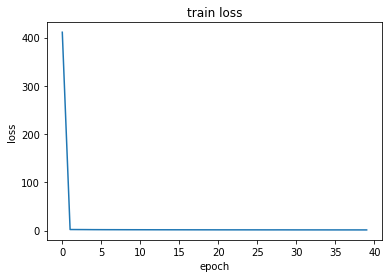

In [14]:
plt.plot(train_losses)
plt.title("train loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

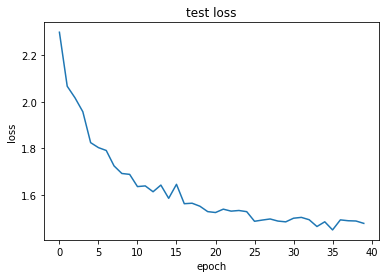

In [15]:
plt.plot(test_losses)
plt.title("test loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

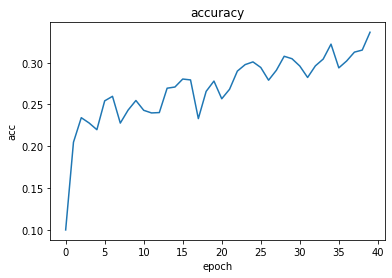

In [16]:
plt.plot(accuracy)
plt.title("accuracy")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.show()

In [17]:
def plot_conf_matrix(cm,classes, nomalize=False, cmap=plt.cm.Blues):
  plt.figure(figsize = (12,7))
  plt.imshow(cm, interpolation='nearest',cmap=cmap)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks,classes, rotation=45)
  plt.yticks(tick_marks,classes)
  fmt='.2f'
  thresh=cm.max() / 2
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
      plt.text(j,i,format(cm[i,j],fmt),
               horizontalalignment="center",
               color="white" if cm[i,j] > thresh else "black") 
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()



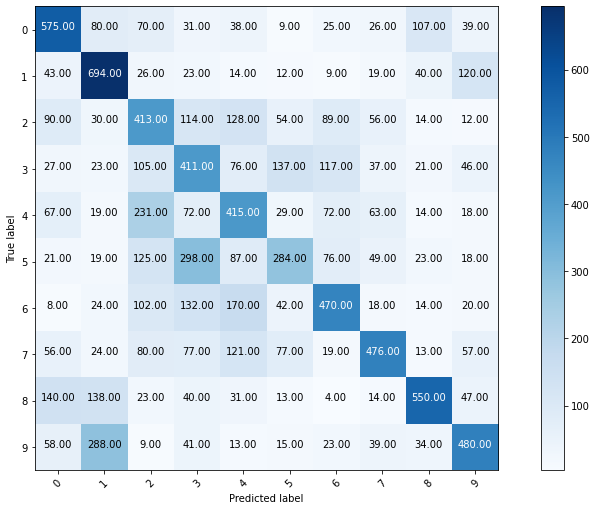

In [18]:
p_test=np.array([])
for datas, targets in validation_generator32:
  datas, targets= datas.to(device), targets.to(device)
  # datas=torch.permute(datas,(0,3,1,2))
  datas=datas.squeeze(2)
  # targets=targets.squeeze(2)
  outputs=cifar10model(datas)
  _,prediction=torch.max(outputs,1)
  p_test=np.concatenate((p_test,prediction.cpu().detach().numpy()))
cm=confusion_matrix(np.array(y_test32),p_test)
plot_conf_matrix(cm,list(range(10)))